# Part 7: Token-based — BPE tokenizer + category–sequence attention

This notebook uses:
- **`tokenizer`** — BPE tokenizer with special tokens `<PAD>` (id 0) and `<EOS>` (id 1)
- **`data_loading`** — dataset download, normalization, category vocabulary, and **token-level** dataset building
- **`model`** — `CategoryConditionedNameModel` for category-conditioned **next-token** prediction

**Model:** Words are tokenized with BPE; (X, Y, C) are token-level. The trunk has:
- **Category → sequence** cross-attention (category queries the sequence)
- **Sequence → category** cross-attention (sequence queries the category) for stronger interplay
- Causal self-attention blocks  
All trunk and MLP layers use **pre-norm** (LayerNorm before linear/attention); the **final logits layer** is not normalized.

In [1]:
import sys
from pathlib import Path

# Ensure project root is on path (run from repo root or from part6)
root = Path.cwd() if Path.cwd().name != "part7" else Path.cwd().parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

from category_groups import CATEGORY_GROUP_MAP

from data_loading import (
    load_words_and_categories,
    build_category_vocabulary,
    get_train_val_test_splits_tokens,
    validate_dataset,
)
from tokenizer import BPETokenizer, tokenizer_vocab
from model import CategoryConditionedNameModel, ModelConfig

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()

Using device: cuda
GPU: NVIDIA GeForce RTX 5060


In [2]:
import kagglehub

dataset_path = kagglehub.dataset_download("isaacbenge/fantasy-for-markov-generator")
print(f"Dataset path: {dataset_path}")

d:\dev\namegens\namegens\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset path: C:\Users\Fern_PC II\.cache\kagglehub\datasets\isaacbenge\fantasy-for-markov-generator\versions\1


In [3]:
# Load words and categories (optional: add extra CSV)

words, categories = load_words_and_categories(
    dirs_configs = [{"dir_path": dataset_path}],
    files_configs = [
        {"file_path": Path("../data/forgotten_realms_inhabitants_by_race.csv"), "name_column": "name", "category_column": "source_category"}, 
        {"file_path": Path("../data/names_multiplied.csv"), "name_column": "full_name", "category_column": "category"},
        ]
)
print(f"Loaded {len(words)} words with {len(categories)} categories")

Loaded 382320 words with 382320 categories


In [4]:
cat_vocab = build_category_vocabulary(categories, use_category_groups=True)
cat_vocab.itos

{0: 'Aberrations',
 1: 'Beastfolk',
 2: 'Beasts',
 3: 'Celestials',
 4: 'Constructs',
 5: 'Dragons',
 6: 'Dwarves',
 7: 'East Asian',
 8: 'Elementals',
 9: 'Elves',
 10: 'Fey',
 11: 'Fiends',
 12: 'Genies',
 13: 'Giants',
 14: 'Gith',
 15: 'Gnolls',
 16: 'Gnomes',
 17: 'Goblinoids',
 18: 'Halflings',
 19: 'Human (General)',
 20: 'Human (Modern)',
 21: 'Kobolds',
 22: 'Mesoamerican',
 23: 'Middle Eastern / Arabian',
 24: 'Monstrosities',
 25: 'Oozes',
 26: 'Orcs',
 27: 'Organizations / Meta',
 28: 'Outsiders',
 29: 'Planar Hybrids',
 30: 'Plants',
 31: 'South Asian',
 32: 'Spirits',
 33: 'Undead',
 34: 'Yuan-ti',
 35: 'Yugoloths'}

In [5]:
# BPE tokenizer with special tokens <PAD> (id 0) and <EOS> (id 1)
tokenizer = BPETokenizer(vocab_size=200).fit(words)
token_vocab = tokenizer_vocab(tokenizer)

print(f"Token vocab size: {tokenizer.size}")
print(f"Category vocab size: {cat_vocab.size}")
print(f"Pad token id: {tokenizer.pad_token_id} (<PAD>)")
print(f"End token id: {tokenizer.end_token_id} (<EOS>)")
print(f"Sample tokens (first 20): {dict(list(tokenizer.itos.items())[:20])}")

Token vocab size: 200
Category vocab size: 36
Pad token id: 0 (<PAD>)
End token id: 1 (<EOS>)
Sample tokens (first 20): {0: '<PAD>', 1: '<EOS>', 2: ' ', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q'}


In [6]:
tokenizer.itos.items()

dict_items([(0, '<PAD>'), (1, '<EOS>'), (2, ' '), (3, 'a'), (4, 'b'), (5, 'c'), (6, 'd'), (7, 'e'), (8, 'f'), (9, 'g'), (10, 'h'), (11, 'i'), (12, 'j'), (13, 'k'), (14, 'l'), (15, 'm'), (16, 'n'), (17, 'o'), (18, 'p'), (19, 'q'), (20, 'r'), (21, 's'), (22, 't'), (23, 'u'), (24, 'v'), (25, 'w'), (26, 'x'), (27, 'y'), (28, 'z'), (29, 'an'), (30, 'a '), (31, 'ar'), (32, 'er'), (33, 'in'), (34, 'ka'), (35, 'i '), (36, 'on'), (37, 'ra'), (38, 'ma'), (39, 'es'), (40, 'en'), (41, 'e '), (42, 'hi'), (43, 'o '), (44, 'el'), (45, 'un'), (46, 'as'), (47, 'al'), (48, 'os'), (49, 'mi'), (50, 'or'), (51, 'ch'), (52, 'da'), (53, 'ta'), (54, 'th'), (55, 'is'), (56, 'gu'), (57, 'wa'), (58, 'ei'), (59, 'u '), (60, 'pa'), (61, 'il'), (62, 'sa'), (63, 'ga'), (64, 'ha'), (65, 'and'), (66, 'ri'), (67, 'ro'), (68, 'ki'), (69, 'su'), (70, 'ku'), (71, 'ara'), (72, 'ing'), (73, 'mu'), (74, 'ya'), (75, 'er '), (76, 'la'), (77, 'na'), (78, 'ho'), (79, 'to'), (80, 're'), (81, 'chi'), (82, 'mar'), (83, 'ko'), (84, 

In [7]:
# Train/val/test splits (token-level)
block_size = 24

(Xtr, Ytr, Ctr), (Xdev, Ydev, Cdev), (Xte, Yte, Cte) = get_train_val_test_splits_tokens(
    words,
    cat_vocab.normalized_categories,
    tokenizer,
    cat_vocab,
    block_size,
    train_frac=0.95,
    val_frac=0.03,
    seed=42,
)

print(f"Train: {Xtr.shape[0]}, Val: {Xdev.shape[0]}, Test: {Xte.shape[0]}")

Building train/val/test datasets (token-level)...
  Skipped 1 empty words.
  Shapes: X 3220965 x 24, Y 3220965, C 3220965
  Tensors: X torch.Size([3220965, 24]), Y torch.Size([3220965]), C torch.Size([3220965])
  Shapes: X 101634 x 24, Y 101634, C 101634
  Tensors: X torch.Size([101634, 24]), Y torch.Size([101634]), C torch.Size([101634])
  Shapes: X 67837 x 24, Y 67837, C 67837
  Tensors: X torch.Size([67837, 24]), Y torch.Size([67837]), C torch.Size([67837])
  Train: 3220965, Val: 101634, Test: 67837
Train: 3220965, Val: 101634, Test: 67837


In [8]:
# Validate datasets (use token_vocab for vocab size)
validate_dataset(Xtr, Ytr, Ctr, token_vocab, cat_vocab)

# Sanity checks before training
assert Ytr.max() < tokenizer.size and Ytr.min() >= 0
assert not torch.isnan(Ytr).any()


DATASET VALIDATION
Vocab size: 200
Shapes: X torch.Size([3220965, 24]), Y torch.Size([3220965]), C torch.Size([3220965])
  No NaNs in X, Y, C.
  X indices in [0, 199], Y in [0, 199].
  C indices in [0, 35].
✓ All validation checks passed.



In [9]:
# Model and optimizer
g = torch.Generator().manual_seed(2147483647)

config = ModelConfig(
    vocab_size=tokenizer.size,
    cat_vocab_size=cat_vocab.size,
    block_size=block_size,
    n_embd=256,
    n_hidden=512,
    num_heads=8,
    num_attention_blocks=4,
    num_mlp_layers=4,
    cat_emb_dim=256,
    dropout=0.2,
    last_layer_scale=0.1,
    category_dropout=0.1,
    unknown_category_idx=cat_vocab.stoi.get("unknown", 0),
)
model = CategoryConditionedNameModel(config).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {n_params:,}")

learning_rate = 1e-3
weight_decay = 0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
n_iter = 500_000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_iter, eta_min=1e-4)

Parameters: 13,568,000


In [10]:
# Training helpers: get_batch, estimate_loss, format_time
batch_size = 256
eval_iters = 100
eval_interval = 10000
track_interval = 100

def get_batch(split: str, batch_size: int):
    data = {"train": (Xtr, Ytr, Ctr), "val": (Xdev, Ydev, Cdev), "test": (Xte, Yte, Cte)}
    X, Y, C = data[split]
    ix = torch.randint(0, X.shape[0], (batch_size,), device=X.device)
    return X[ix].to(device), Y[ix].to(device), C[ix].to(device)

@torch.no_grad()
def estimate_loss(model, eval_iters: int, batch_size: int):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters, device=device)
        for k in range(eval_iters):
            Xb, Yb, Cb = get_batch(split, batch_size)
            _, loss = model(Xb, Cb, targets=Yb)
            losses[k] = loss
        out[split] = losses.mean().item()
    model.train()
    return out

def format_time(seconds: float) -> str:
    s = int(seconds)
    h, s = divmod(s, 3600)
    m, s = divmod(s, 60)
    if h > 0:
        return f"{h}h {m}m {s}s"
    if m > 0:
        return f"{m}m {s}s"
    return f"{s}s"

In [11]:
# Training loop: progress bar, validation, LR decay, gradient clipping, early stopping
lossi = []
val_lossi = []
n_track = n_iter // track_interval
lossi_gpu = torch.zeros(n_track, device=device)
val_lossi_gpu = torch.zeros(n_track, device=device)
loss_tracker_idx = 0
best_val_loss = float("inf")
patience = 10
patience_counter = 0
early_stop = False

start_time = time.time()
pbar = tqdm(range(n_iter), desc="Training", unit="iter", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

for i in pbar:
    Xb, Yb, Cb = get_batch("train", batch_size)
    model.train()
    optimizer.zero_grad(set_to_none=True)
    logits, loss = model(Xb, Cb, targets=Yb)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    if i % 10 == 0:
        elapsed = time.time() - start_time
        iters_per_sec = (i + 1) / elapsed if elapsed > 0 else 0
        eta_sec = (n_iter - (i + 1)) / iters_per_sec if iters_per_sec > 0 else 0
        pbar.set_postfix(loss=f"{loss.item():.4f}", it_s=f"{iters_per_sec:.1f}", ETA=format_time(eta_sec))

    if i % track_interval == 0:
        lossi_gpu[loss_tracker_idx] = loss.detach()
        model.eval()
        with torch.no_grad():
            Xv, Yv, Cv = get_batch("val", batch_size)
            _, val_loss = model(Xv, Cv, targets=Yv)
            val_lossi_gpu[loss_tracker_idx] = val_loss.detach()
        model.train()
        loss_tracker_idx += 1

    if i % eval_interval == 0:
        losses = estimate_loss(model, eval_iters, batch_size)
        elapsed = time.time() - start_time
        iters_per_sec = (i + 1) / elapsed if elapsed > 0 else 0
        current_lr = scheduler.get_last_lr()[0]

        if losses["val"] < best_val_loss:
            best_val_loss = losses["val"]
            patience_counter = 0
            torch.save(model.state_dict(), "part6_best.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                early_stop = True
                tqdm.write(f"\nEarly stopping. Best val loss: {best_val_loss:.4f}")
                break

        tqdm.write(f"\nStep {i}/{n_iter}: train={losses['train']:.4f} val={losses['val']:.4f} (best={best_val_loss:.4f}) lr={current_lr:.6f} {iters_per_sec:.1f} it/s patience={patience_counter}/{patience}")

lossi = lossi_gpu[:loss_tracker_idx].cpu().tolist()
val_lossi = val_lossi_gpu[:loss_tracker_idx].cpu().tolist()
total_time = time.time() - start_time
if early_stop:
    print(f"\nStopped early after {format_time(total_time)}. Loading best model.")
    model.load_state_dict(torch.load("part6_best.pt", map_location=device))
else:
    print(f"\nDone in {format_time(total_time)}. Best val loss: {best_val_loss:.4f}")
model.eval()

Training:   0%|          | 4/500000 [00:03<94:54:08,  1.46iter/s] 


Step 0/500000: train=5.1670 val=5.1649 (best=5.1649) lr=0.001000 0.3 it/s patience=0/10


Training:   2%|▏         | 10005/500000 [06:52<38:34:17,  3.53iter/s]


Step 10000/500000: train=1.8490 val=1.8538 (best=1.8538) lr=0.000999 24.3 it/s patience=0/10


Training:   4%|▍         | 20004/500000 [13:32<31:35:40,  4.22iter/s]


Step 20000/500000: train=1.7559 val=1.7620 (best=1.7620) lr=0.000996 24.6 it/s patience=0/10


Training:   6%|▌         | 30004/500000 [20:08<27:48:59,  4.69iter/s]


Step 30000/500000: train=1.7251 val=1.7738 (best=1.7620) lr=0.000992 24.8 it/s patience=1/10


Training:   8%|▊         | 40004/500000 [26:45<30:47:57,  4.15iter/s]


Step 40000/500000: train=1.7109 val=1.7224 (best=1.7224) lr=0.000986 24.9 it/s patience=0/10


Training:  10%|█         | 50004/500000 [33:22<28:15:47,  4.42iter/s]


Step 50000/500000: train=1.6978 val=1.7149 (best=1.7149) lr=0.000978 25.0 it/s patience=0/10


Training:  12%|█▏        | 60005/500000 [39:58<24:14:57,  5.04iter/s]


Step 60000/500000: train=1.7120 val=1.7213 (best=1.7149) lr=0.000968 25.0 it/s patience=1/10


Training:  14%|█▍        | 70005/500000 [46:35<24:44:49,  4.83iter/s]


Step 70000/500000: train=1.6862 val=1.7292 (best=1.7149) lr=0.000957 25.0 it/s patience=2/10


Training:  16%|█▌        | 80004/500000 [53:11<29:12:07,  4.00iter/s]


Step 80000/500000: train=1.7041 val=1.7002 (best=1.7002) lr=0.000944 25.1 it/s patience=0/10


Training:  18%|█▊        | 90005/500000 [59:48<23:59:57,  4.75iter/s]


Step 90000/500000: train=1.6834 val=1.7169 (best=1.7002) lr=0.000930 25.1 it/s patience=1/10


Training:  20%|██        | 100004/500000 [1:06:27<25:03:59,  4.43iter/s]


Step 100000/500000: train=1.6705 val=1.6968 (best=1.6968) lr=0.000914 25.1 it/s patience=0/10


Training:  22%|██▏       | 110004/500000 [1:13:05<24:19:27,  4.45iter/s]


Step 110000/500000: train=1.6982 val=1.7066 (best=1.6968) lr=0.000897 25.1 it/s patience=1/10


Training:  24%|██▍       | 120004/500000 [1:19:40<24:13:25,  4.36iter/s]


Step 120000/500000: train=1.6832 val=1.6892 (best=1.6892) lr=0.000878 25.1 it/s patience=0/10


Training:  26%|██▌       | 130004/500000 [1:26:15<22:38:05,  4.54iter/s]


Step 130000/500000: train=1.6710 val=1.7041 (best=1.6892) lr=0.000858 25.1 it/s patience=1/10


Training:  28%|██▊       | 140004/500000 [1:32:53<27:36:18,  3.62iter/s]


Step 140000/500000: train=1.6743 val=1.6755 (best=1.6755) lr=0.000837 25.1 it/s patience=0/10


Training:  30%|███       | 150004/500000 [1:39:31<24:05:29,  4.04iter/s]


Step 150000/500000: train=1.6747 val=1.6555 (best=1.6555) lr=0.000815 25.1 it/s patience=0/10


Training:  32%|███▏      | 160005/500000 [1:46:07<19:31:14,  4.84iter/s]


Step 160000/500000: train=1.6565 val=1.7036 (best=1.6555) lr=0.000791 25.1 it/s patience=1/10


Training:  34%|███▍      | 170005/500000 [1:52:44<18:33:04,  4.94iter/s]


Step 170000/500000: train=1.6332 val=1.6695 (best=1.6555) lr=0.000767 25.1 it/s patience=2/10


Training:  36%|███▌      | 180004/500000 [1:59:20<20:37:15,  4.31iter/s]


Step 180000/500000: train=1.6608 val=1.6906 (best=1.6555) lr=0.000742 25.1 it/s patience=3/10


Training:  38%|███▊      | 190004/500000 [2:05:56<21:27:22,  4.01iter/s]


Step 190000/500000: train=1.6466 val=1.6639 (best=1.6555) lr=0.000716 25.1 it/s patience=4/10


Training:  40%|████      | 200005/500000 [2:12:34<19:42:48,  4.23iter/s]


Step 200000/500000: train=1.6622 val=1.6610 (best=1.6555) lr=0.000689 25.1 it/s patience=5/10


Training:  42%|████▏     | 210004/500000 [2:19:10<19:39:06,  4.10iter/s]


Step 210000/500000: train=1.6407 val=1.6677 (best=1.6555) lr=0.000662 25.1 it/s patience=6/10


Training:  44%|████▍     | 220005/500000 [2:25:47<16:02:36,  4.85iter/s]


Step 220000/500000: train=1.6068 val=1.6877 (best=1.6555) lr=0.000634 25.2 it/s patience=7/10


Training:  46%|████▌     | 230005/500000 [2:32:24<23:03:59,  3.25iter/s]


Step 230000/500000: train=1.6142 val=1.6455 (best=1.6455) lr=0.000606 25.2 it/s patience=0/10


Training:  48%|████▊     | 240004/500000 [2:39:02<19:19:50,  3.74iter/s]


Step 240000/500000: train=1.6206 val=1.6376 (best=1.6376) lr=0.000578 25.2 it/s patience=0/10


Training:  50%|█████     | 250004/500000 [2:45:41<15:27:08,  4.49iter/s]


Step 250000/500000: train=1.6185 val=1.6398 (best=1.6376) lr=0.000550 25.1 it/s patience=1/10


Training:  52%|█████▏    | 260004/500000 [2:52:17<15:27:08,  4.31iter/s]


Step 260000/500000: train=1.5923 val=1.6142 (best=1.6142) lr=0.000522 25.2 it/s patience=0/10


Training:  54%|█████▍    | 270004/500000 [2:58:54<15:09:19,  4.22iter/s]


Step 270000/500000: train=1.5907 val=1.6297 (best=1.6142) lr=0.000494 25.2 it/s patience=1/10


Training:  56%|█████▌    | 280005/500000 [3:05:31<12:28:59,  4.90iter/s]


Step 280000/500000: train=1.5955 val=1.6464 (best=1.6142) lr=0.000466 25.2 it/s patience=2/10


Training:  58%|█████▊    | 290005/500000 [3:12:07<11:55:31,  4.89iter/s]


Step 290000/500000: train=1.5725 val=1.6294 (best=1.6142) lr=0.000438 25.2 it/s patience=3/10


Training:  60%|██████    | 300005/500000 [3:18:44<12:24:11,  4.48iter/s]


Step 300000/500000: train=1.5967 val=1.6222 (best=1.6142) lr=0.000411 25.2 it/s patience=4/10


Training:  62%|██████▏   | 310005/500000 [3:25:20<10:40:57,  4.94iter/s]


Step 310000/500000: train=1.5771 val=1.6144 (best=1.6142) lr=0.000384 25.2 it/s patience=5/10


Training:  64%|██████▍   | 320004/500000 [3:31:57<11:38:22,  4.30iter/s]


Step 320000/500000: train=1.5762 val=1.6321 (best=1.6142) lr=0.000358 25.2 it/s patience=6/10


Training:  66%|██████▌   | 330005/500000 [3:38:34<12:14:02,  3.86iter/s]


Step 330000/500000: train=1.5598 val=1.6077 (best=1.6077) lr=0.000333 25.2 it/s patience=0/10


Training:  68%|██████▊   | 340004/500000 [3:45:12<11:36:39,  3.83iter/s]


Step 340000/500000: train=1.5354 val=1.5942 (best=1.5942) lr=0.000309 25.2 it/s patience=0/10


Training:  70%|███████   | 350005/500000 [3:51:48<8:33:32,  4.87iter/s] 


Step 350000/500000: train=1.5387 val=1.5958 (best=1.5942) lr=0.000285 25.2 it/s patience=1/10


Training:  72%|███████▏  | 360004/500000 [3:58:26<9:09:13,  4.25iter/s] 


Step 360000/500000: train=1.5423 val=1.5930 (best=1.5930) lr=0.000263 25.2 it/s patience=0/10


Training:  74%|███████▍  | 370004/500000 [4:05:04<8:45:13,  4.13iter/s] 


Step 370000/500000: train=1.5347 val=1.5911 (best=1.5911) lr=0.000242 25.2 it/s patience=0/10


Training:  76%|███████▌  | 380004/500000 [4:11:41<7:24:53,  4.50iter/s]


Step 380000/500000: train=1.5317 val=1.5875 (best=1.5875) lr=0.000222 25.2 it/s patience=0/10


Training:  78%|███████▊  | 390005/500000 [4:18:20<7:41:29,  3.97iter/s]


Step 390000/500000: train=1.5378 val=1.5701 (best=1.5701) lr=0.000203 25.2 it/s patience=0/10


Training:  80%|████████  | 400004/500000 [4:24:57<6:36:05,  4.21iter/s]


Step 400000/500000: train=1.5364 val=1.5716 (best=1.5701) lr=0.000186 25.2 it/s patience=1/10


Training:  82%|████████▏ | 410004/500000 [4:31:34<5:40:25,  4.41iter/s]


Step 410000/500000: train=1.5135 val=1.5857 (best=1.5701) lr=0.000170 25.2 it/s patience=2/10


Training:  84%|████████▍ | 420005/500000 [4:38:11<4:31:16,  4.91iter/s]


Step 420000/500000: train=1.5083 val=1.5793 (best=1.5701) lr=0.000156 25.2 it/s patience=3/10


Training:  86%|████████▌ | 430004/500000 [4:44:49<4:50:51,  4.01iter/s]


Step 430000/500000: train=1.4961 val=1.5600 (best=1.5600) lr=0.000143 25.2 it/s patience=0/10


Training:  88%|████████▊ | 440005/500000 [4:51:25<3:27:35,  4.82iter/s]


Step 440000/500000: train=1.5100 val=1.5750 (best=1.5600) lr=0.000132 25.2 it/s patience=1/10


Training:  90%|█████████ | 450005/500000 [4:58:01<3:17:29,  4.22iter/s]


Step 450000/500000: train=1.5007 val=1.5813 (best=1.5600) lr=0.000122 25.2 it/s patience=2/10


Training:  92%|█████████▏| 460005/500000 [5:04:39<2:18:15,  4.82iter/s]


Step 460000/500000: train=1.5117 val=1.5612 (best=1.5600) lr=0.000114 25.2 it/s patience=3/10


Training:  94%|█████████▍| 470005/500000 [5:11:15<1:44:07,  4.80iter/s]


Step 470000/500000: train=1.4710 val=1.5681 (best=1.5600) lr=0.000108 25.2 it/s patience=4/10


Training:  96%|█████████▌| 480006/500000 [5:17:53<1:17:43,  4.29iter/s]


Step 480000/500000: train=1.5001 val=1.5503 (best=1.5503) lr=0.000104 25.2 it/s patience=0/10


Training:  98%|█████████▊| 490004/500000 [5:24:30<42:08,  3.95iter/s]  


Step 490000/500000: train=1.4848 val=1.5492 (best=1.5492) lr=0.000101 25.2 it/s patience=0/10


Training: 100%|██████████| 500000/500000 [5:31:04<00:00, 25.17iter/s]



Done in 5h 31m 4s. Best val loss: 1.5492


CategoryConditionedNameModel(
  (token_embedding): Embedding(200, 256)
  (cat_embedding): Embedding(36, 256)
  (project): Linear(in_features=256, out_features=512, bias=False)
  (blocks): ModuleList(
    (0): AdaLNBlockWithContext(
      (adaln): AdaptiveLayerNorm(
        (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=False)
        (cond_proj): Linear(in_features=256, out_features=1024, bias=True)
      )
    )
    (1): TrunkBlockWithContext(
      (cross_attn): CategoryCrossAttention(
        (ln_x): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ln_cat): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (cat_query): Linear(in_features=256, out_features=512, bias=False)
        (seq_key): Linear(in_features=512, out_features=512, bias=False)
        (seq_value): Linear(in_features=512, out_features=512, bias=False)
        (proj): Linear(in_features=512, out_features=512, bias=False)
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
  

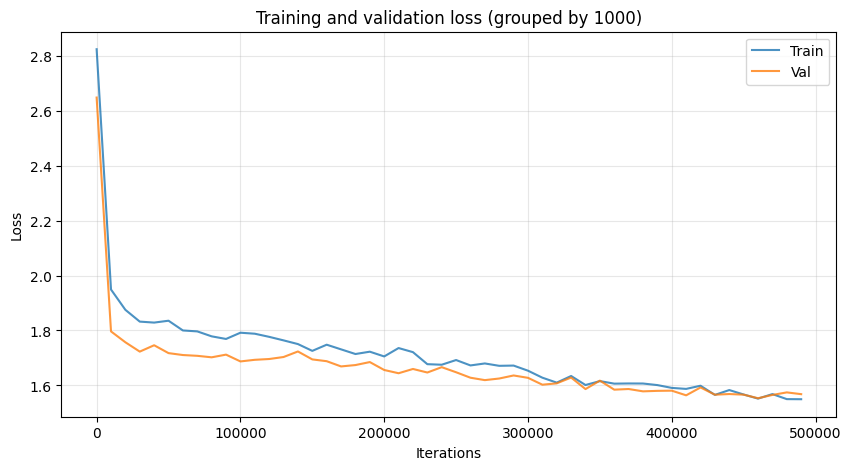

In [12]:
# Plot training and validation loss (each point = track_interval iters)
lossi = lossi_gpu[:loss_tracker_idx].cpu().tolist()
val_lossi = val_lossi_gpu[:loss_tracker_idx].cpu().tolist()
total_time = time.time() - start_time

if len(lossi) > 0:
    lossi_tensor = torch.tensor(lossi)
    val_lossi_tensor = torch.tensor(val_lossi)
    group_size = 100
    n_complete = (len(lossi_tensor) // group_size) * group_size

    lossi_grouped = lossi_tensor[:n_complete].view(-1, group_size).mean(dim=1)
    val_lossi_grouped = val_lossi_tensor[:n_complete].view(-1, group_size).mean(dim=1)
    iterations = torch.arange(lossi_grouped.numel()) * (track_interval * group_size)

    plt.figure(figsize=(10, 5))
    plt.plot(iterations, lossi_grouped.tolist(), label="Train", alpha=0.8)
    plt.plot(iterations, val_lossi_grouped.tolist(), label="Val", alpha=0.8)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training and validation loss (grouped by 1000)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No loss history (training not run or no track_interval points).")

In [13]:
# Evaluation: train and val loss
@torch.no_grad()
def split_loss(split: str) -> float:
    model.eval()
    splits = {
        "train": (Xtr, Ytr, Ctr),
        "val": (Xdev, Ydev, Cdev),
        "test": (Xte, Yte, Cte),
    }
    X, Y, C = splits[split]
    n = min(2048, X.shape[0])
    Xb = X[:n].to(device)
    Yb = Y[:n].to(device)
    Cb = C[:n].to(device)
    logits, _ = model(Xb, Cb, targets=Yb)
    loss = F.cross_entropy(logits, Yb)
    return loss.item()

# print(f"Train loss: {split_loss('train'):.4f}")
print(f"Val loss:   {split_loss('val'):.4f}")

Val loss:   1.5744


In [14]:
# Generate names for a given category
gen = torch.Generator(device=device).manual_seed(2147483647 + 1)

cat_name = "dwarves"
cat_idx = next((k for k, v in cat_vocab.itos.items() if v.lower() == cat_name), 0)

for _ in range(15):
    name = model.generate_name(
        cat_idx, tokenizer.itos, tokenizer.stoi,
        generator=gen, replace_end_with=None,
        end_token_id=tokenizer.end_token_id, pad_token_id=tokenizer.pad_token_id,
    )
    print(f"[{cat_name}] {name}")

[dwarves] rhik ssey mumedberw
[dwarves] avlyy stonefist
[dwarves] hoick dalsway
[dwarves] radagar minguslu
[dwarves] tshield andi stones
[dwarves] ward brighthelm
[dwarves] nolob
[dwarves] axga
[dwarves] ywurchia wongue sper
[dwarves] krathgar bornarmir
[dwarves] lurto browkyrom
[dwarves] corna grdes
[dwarves] milik derluth
[dwarves] warnever
[dwarves] quintri


In [15]:
# Generate names for a given category
gen = torch.Generator(device=device).manual_seed(2147483647 + 1)

cat_name = "elves"
cat_idx = next((k for k, v in cat_vocab.itos.items() if v.lower() == cat_name), 0)

for _ in range(15):
    name = model.generate_name(
        cat_idx, tokenizer.itos, tokenizer.stoi,
        generator=gen, temperature=0.5, replace_end_with=" ",
        end_token_id=tokenizer.end_token_id, pad_token_id=tokenizer.pad_token_id,
    )
    print(f"[{cat_name}] {name}")

[elves] rystia szind lan
[elves] vaeril silverstar icross
[elves] shaveriel nollgus vericelden
[elves] elimbra baenre
[elves] sillstar stelwood
[elves] elwar freth lord
[elves] kessa lorning barr stars
[elves] delath hawksong del
[elves] delath hawktyn e
[elves] seldyn starym ster
[elves] elimon hawkryn ett
[elves] celath freth melern
[elves] star beldorn star
[elves] alexandra winderwood the dsprow
[elves] belak baenre thil


In [19]:
# Generate names for a given category
gen = torch.Generator(device=device).manual_seed(2147483647 + 1)

cat_name = "Humans (General)"
cat_idx = next((k for k, v in cat_vocab.itos.items() if v.lower() == cat_name), 0)

for _ in range(15):
    name = model.generate_name(
        cat_idx, tokenizer.itos, tokenizer.stoi,
        generator=gen, temperature=0.5, replace_end_with=" ",
        end_token_id=tokenizer.end_token_id, pad_token_id=tokenizer.pad_token_id,
    )
    print(f"[{cat_name}] {name}")

[Humans (General)] rin spooner no
[Humans (General)] joshua black id i
[Humans (General)] fernando guimaraes i
[Humans (General)] ngampangampala tanuma belfastos
[Humans (General)] pundraki bishop baus
[Humans (General)] nun black mer
[Humans (General)] bringer barata ada
[Humans (General)] naoto guimaraes bos
[Humans (General)] shade of silver spring gasakaa mi
[Humans (General)] madalena alves s
[Humans (General)] parnpala west spooner
[Humans (General)] warlkapandhinanhunu aasu cidle
[Humans (General)] malandyi saito hol
[Humans (General)] mama milton heele
[Humans (General)] masakimasaaki aoea vereclin andre


In [17]:
# Random category sampling
import random

gen = torch.Generator(device=device).manual_seed(2147483647 + 22)
cat_indices = list(cat_vocab.itos.keys())

for _ in range(30):
    c = random.choice(cat_indices)
    cat_label = cat_vocab.itos[c]
    name = model.generate_name(
        c, tokenizer.itos, tokenizer.stoi, generator=gen,
        end_token_id=tokenizer.end_token_id, pad_token_id=tokenizer.pad_token_id,
    )
    print(f"[{cat_label}] {name}")

[Giants] hermil courl
[Elementals] sker guith
[Elementals] warcremon mephit
[Dwarves] limsravlis dovart
[Human (General)] gu stave restuccia ale
[Yuan-ti] sessald nod ridlilan medrus
[Oozes] shadowsskeksha khiglasliy
[Undead] elyss zrin vargher
[Elementals] sandling bar
[Constructs] ne golem
[East Asian] tra chandree
[Plants] sjadrache stoeu
[South Asian] nirali jain zamindar
[Organizations / Meta] candace cardoso doso
[Plants] verttant thresta hyryutor
[Goblinoids] gradsk lincand
[Genies] amaraz allkrin
[Fey] ketemptie sspandya mallrivi
[Undead] madal nanthasax
[Kobolds] kastur ped
[Genies] obroha im
[Outsiders] drobze dread mephit
[Yugoloths] nycer vawa
[Gnomes] sar waedx blaker
[Gnolls] srighutter oot
[Kobolds] glasix peerleb
[Beastfolk] lightfox sau hound
[Human (Modern)] maisie simmond gloron
[Plants] arip waropear 
[Planar Hybrids] hylak aelarn


In [18]:
# Random category sampling
import random

gen = torch.Generator(device=device).manual_seed(2147483647 + 22)
cat_indices = list(cat_vocab.itos.keys())

for c in cat_indices:
    for i in range(10):
        cat_label = cat_vocab.itos[c]
        name = model.generate_name(
            c, tokenizer.itos, tokenizer.stoi, generator=gen,
            end_token_id=tokenizer.end_token_id, pad_token_id=tokenizer.pad_token_id,
        )
        print(f"[{cat_label}] {name}")

[Aberrations] henmu domingues sun
[Aberrations] puza matsushita ta
[Aberrations] wanthanhulu chong ravlen
[Aberrations] elvagar the polorn bard mistall
[Aberrations] carl clark milder
[Aberrations] talitha yamazaki s
[Aberrations] gukegun mei go
[Aberrations] kitlehenake sogee vares
[Aberrations] luis gerua boswell
[Aberrations] ngampa posokaa math
[Beastfolk] graston efodculer
[Beastfolk] sjall ironk cantle
[Beastfolk] drak drount
[Beastfolk] tttanti rrefist
[Beastfolk] witor fratifl
[Beastfolk] wocon woust
[Beastfolk] taurk thoumbleti
[Beastfolk] glordop maliti
[Beastfolk] alliza trollahxo
[Beastfolk] stsheor hallim dey
[Beasts] brost malar
[Beasts] read wolf gboar wolt
[Beasts] smari pony
[Beasts] stamun polctter stuw
[Beasts] wsimon peclebi h
[Beasts] rock night je
[Beasts] malch of malani
[Beasts] rozzlac wolon
[Beasts] pear bat
[Beasts] sisk podov
[Celestials] spirit despadel
[Celestials] beladiel of gia
[Celestials] dalimon sorderfoth ol
[Celestials] zmara eldeval
[Celestials] s